In [48]:
# Data Structure
import numpy as np
import pandas as pd

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,confusion_matrix,pairwise_distances
from sklearn.ensemble import RandomForestRegressor
import itertools
from scipy.sparse.linalg import svds

#Graphing
import matplotlib.pyplot as plt

In [2]:
def data_clean(df, feature, m):
    count = df[feature].value_counts()
    df = df[df[feature].isin(count[count > m].index)]
    return df

In [3]:
def data_clean_sum(df,features,m):
    count_product_id=df.ProductId.value_counts()
    count_user_id=df.UserId.value_counts()
    df['#Pro']=df.ProductId.apply(lambda x:count_product_id[x])
    df['#Users']=df.UserId.apply(lambda x:count_user_id[x])
    while (df.ProductId.value_counts(ascending=True)[0])<m or (df.UserId.value_counts(ascending=True)[0]<m):
        df=data_clean(df,features[0],m)
        df=data_clean(df,features[1],m)
    return df

In [4]:
def data():
    print('loading data...')
    df=pd.read_csv('../Downloads/Reviews.csv')
    df['datetime']=pd.to_datetime(df.Time,unit='s')
    raw_data=data_clean_sum(df,['ProductId','UserId'],10)
    raw_data['uid']=pd.factorize(raw_data.UserId)[0]
    raw_data['pid']=pd.factorize(raw_data.ProductId)[0]
    sc=MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#Users'].values.reshape(-1,1))
    raw_data['nproduct']=sc.fit_transform(raw_data['#Pro'].values.reshape(-1,1))
    print('Finished Loading data.')
    return raw_data

In [12]:
def plot_confusion_matrix(comfusiontable,classname,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    if normalize:
        cm=comfusiontable.astype('float')/comfusiontable.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks=np.arange(len(classname))
    plt.xticks(tick_marks,classname,rotation=45)
    plt.yticks(tick_marks,classname)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')        

In [5]:
df=data()

loading data...
Finished Loading data.


In [6]:
def user_item_table(df):
    data=df.loc[:,['uid','pid','Score']]
    table=np.zeros([data['uid'].unique().shape[0],data['pid'].unique().shape[0]])
    for i in np.array(data):
        uid,pid,score=i
        if table[uid][pid]<score:
            table[uid][pid]=score
    print('The shape of user-item table is:')
    print(table.shape)
    return(table)

In [7]:
user_item=user_item_table(df)

The shape of user-item table is:
(3666, 1102)


# Random Forest

In [16]:
def randomforst(df):
    X=df.loc[:,['uid','pid','time','nuser','nproduct']]
    Y=df.loc[:,'Score']
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=2019)
    model=RandomForestRegressor()
    model.fit(X_train,Y_train)
    Y_test_predict=model.predict(X_test)
    train_mse=mean_squared_error(Y_train,model.predict(X_train))
    test_mse=mean_squared_error(Y_test,Y_test_predict)
    print('train MSE is {},test MSE is {}'.format(train_mse,test_mse))
    indicate=Y_test_predict>=4
    Y_test_table=np.zeros(len(Y_test))
    Y_test_table[indicate]=1
    indicate=Y_test>=4
    Y_true_table=np.zeros(len(Y_test))
    Y_true_table[indicate]=1
    print('Recomendament Acuuracy is {}, Not Recommendation Accuracy is {}'.format(accuracy_score(Y_test_predict>=4,Y_test>=4),accuracy_score(Y_test_predict<=3,Y_test<=3)))
    class_names = ['not recommand','recommand']
    cnf_matrix = confusion_matrix(Y_true_table,Y_test_table)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classname=class_names, normalize=True,
                          title='rf')
    plt.show()

C:\Users\93444\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train MSE is 0.07002856396647182,test MSE is 0.3476894648721451
Recomendament Acuuracy is 0.8708942078541084, Not Recommendation Accuracy is 0.8956584809864263
Normalized confusion matrix
[[0.89 0.11]
 [0.14 0.86]]


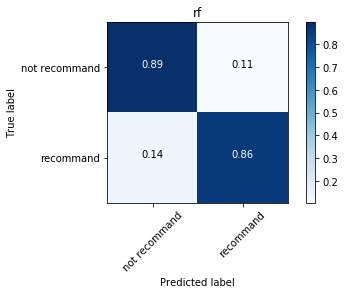

In [17]:
randomforst(df)

# Quasi-SVD

In [42]:
def cosine_similarity(table=user_item,distance='cosine'):
    user_similarity=pairwise_distances(table,metric=distance)
    item_similarity=pairwise_distances(table.T,metric=distance)
    sc=MinMaxScaler()
    result=sc.fit_transform(np.dot(user_similarity,table).dot(item_similarity))
    return result
def rec_result(result,uid,n,rawId=False):
    if uid in range(total_u):
        top_N=np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
        
        if rawId==True:
            print('The real ID is {}'.format(pid2Pid[top_N]))
    else:
        print('Use cold start methods')

pid2Pid=df['ProductId'].unique()
total_u=df['uid'].unique().shape[0]
result=cosine_similarity()
rec_result(result,200,10,rawId=True)

the top10 recommanded products for user 200 is [  52 1051  960    1  620  432  559  883   43 1073]
The real ID is ['B0058AMY74' 'B006WYSFZK' 'B0013LYLIW' 'B000G6MBX2' 'B000GWLUGU'
 'B000G6MBWI' 'B000GWKO7G' 'B0013LYLHS' 'B0013LWJ1S' 'B000GWLR72']


array([  52, 1051,  960,    1,  620,  432,  559,  883,   43, 1073],
      dtype=int64)

# SVD

In [62]:
def svdr(table=user_item,k=100):
    A=np.matrix(table)
    user_ratings_mean=np.mean(A,axis=0)
    user_ratings_mean=user_ratings_mean.reshape(1,-1)
    A_cor=A-user_ratings_mean
    U,sigma,Vt=svds(A_cor,k)
    sigma=np.diag(sigma)
    sc=MinMaxScaler()
    pred=sc.fit_transform(np.dot(U,sigma).dot(Vt)+user_ratings_mean)
    return pred 

In [65]:
result=svdr()
rec_result(result,200,10,rawId=True)

the top10 recommanded products for user 200 is [ 628  131  432 1073  883   43  620    1  559  960]
The real ID is ['B000FNEX8C' 'B000FNB3AI' 'B000G6MBWI' 'B000GWLR72' 'B0013LYLHS'
 'B0013LWJ1S' 'B000GWLUGU' 'B000G6MBX2' 'B000GWKO7G' 'B0013LYLIW']


array([ 628,  131,  432, 1073,  883,   43,  620,    1,  559,  960],
      dtype=int64)